In [4]:
import copy
import random
import os
import argparse
import sys
import numpy as np
import albumentations as A


import cv2
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision
import torchvision.models as models
import torchvision.transforms.functional as TF


from torch.nn import functional as F
from glob import glob
from PIL import Image  
from torchsummary import summary
from urllib.request import urlretrieve
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2

np.set_printoptions(threshold = np.inf) 
np.set_printoptions(suppress = True)

cudnn.benchmark = True


In [5]:
# # Hyperparameters etc.


num_workers = 0
IMAGE_HEIGHT = 512  
IMAGE_WIDTH = 512  
# PIN_MEMORY = True

# os.makedirs("saved_images", exist_ok=True)
epochs = 16
batch_size = 2
lr = 0.0001
img_scale= 0.1,
out_channel= 1
pretrained = False
load_model = False
dir_checkpoint = 'checkpoints/'
os.makedirs("saved_images", exist_ok=True)


In [6]:
images_directory = 'images-1024x768'
masks_directory = 'masks-1024x768'
images_filenames = list(sorted(os.listdir(images_directory)))

random.seed(42)
random.shuffle(images_filenames)

In [7]:
class TinoDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None,mode = 'train' ):

        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform
        
        len_training =  int(len(images_filenames) * (70/100))
        len_val = int(len(images_filenames) * (90/100))

        
        if mode == "train":
            self.images_filenames = self.images_filenames[:len_training] 
        elif mode == "val":
            self.images_filenames = self.images_filenames[len_training:len_val]
        else :
            self.images_filenames = self.images_filenames[len_val:] 


        
    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
      
        
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,
        )


       
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

In [8]:
train_transform = A.Compose(
    [
        A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = TinoDataset(images_filenames=images_filenames, images_directory=images_directory , masks_directory=masks_directory, transform=train_transform,)

val_transform = A.Compose(
    [A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
val_dataset = TinoDataset(images_filenames=images_filenames, images_directory=images_directory , masks_directory=masks_directory, transform=val_transform, mode = 'val')

In [13]:
def visualize_augmentations(dataset, idx=0, samples=10):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    
    figure, ax = plt.subplots(nrows=10, ncols=2, figsize=(10, 24))
   
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, cmap =  'gray',interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

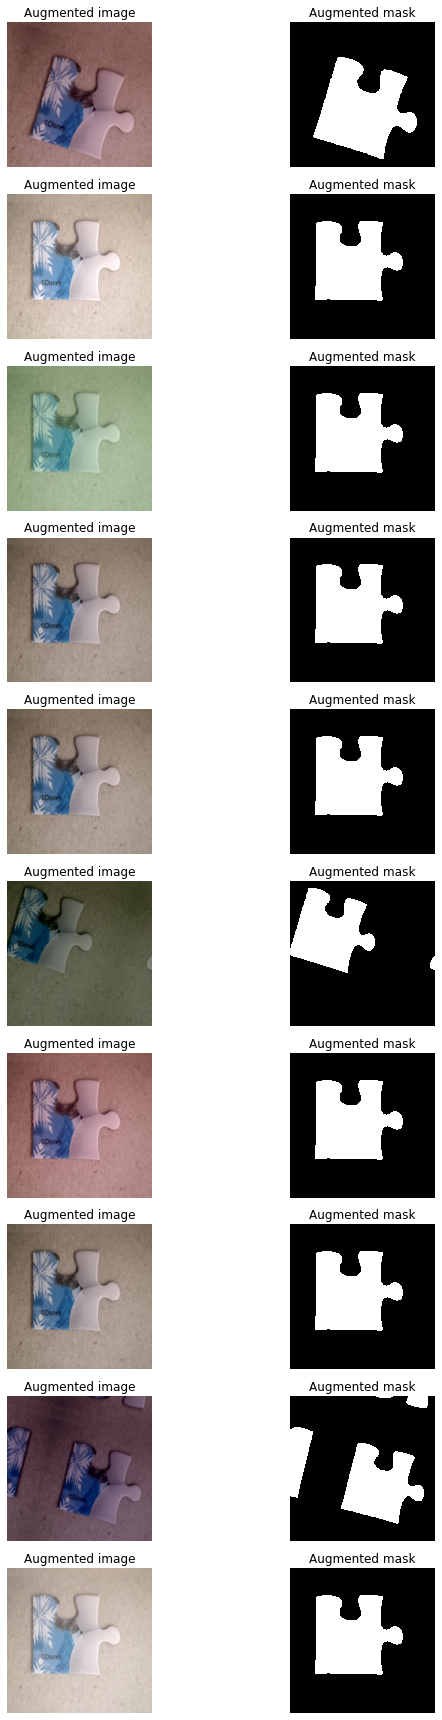

In [14]:
random.seed(42)
visualize_augmentations(train_dataset, idx=1)

#  Network

In [ ]:

def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3,1, 1,bias=False)


class ConvRelu(nn.Module):
    def __init__(self, in_: int, out: int):
        super(ConvRelu, self).__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x





class DecoderBlock(nn.Module):
    """
    Paramaters for Deconvolution were chosen to avoid artifacts, following
    link https://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlock, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2
                                   ),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


class VGG16UNet(nn.Module):
    def __init__(self, out_channel=1, num_filters=32, pretrained=False):
        """
        out_channel:Number of channels of output image
        pretrained: Whether to load the pre-trained model
        """
        super().__init__()
        self.out_channel = out_channel

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.vgg16(pretrained=pretrained).features#The pre-trained model will be downloaded automatically
        print(len(self.encoder))
        self.relu = nn.ReLU(inplace=True)

        self.encoder_conv1_1=nn.Conv2d(out_channel, 64, 3,1,  1)#Modify the first layer of VGG16 to use single-channel images, this part of the parameters.
        '''
        self.conv1 = nn.Sequential(self.encoder_conv1_1,
                                   self.relu,
                                   self.encoder[2],
                                   self.relu)
        '''
        self.conv1 = nn.Sequential(self.encoder[0],
                                   self.relu,
                                   self.encoder[2],
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[5],
                                   self.relu,
                                   self.encoder[7],
                                   self.relu)

        self.conv3 = nn.Sequential(self.encoder[10],
                                   self.relu,
                                   self.encoder[12],
                                   self.relu,
                                #    self.encoder[14],
                                #    self.relu
                                )

        self.conv4 = nn.Sequential(self.encoder[17],
                                   self.relu,
                                   self.encoder[19],
                                   self.relu,
                                #    self.encoder[21],
                                #    self.relu
                                )

        self.conv5 = nn.Sequential(self.encoder[24],
                                   self.relu,
                                   self.encoder[26],
                                   self.relu,
                                #    self.encoder[28],
                                #    self.relu
                                   )

        self.center = DecoderBlock(512, num_filters * 8 * 2, num_filters * 8)

        self.dec5 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8)
        self.dec3 = DecoderBlock(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(128 + num_filters * 2, num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(64 + num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, out_channel, kernel_size=1)
    
    def forward(self, x):
        
        skip_connections = []
        

        conv1 = self.conv1(x)
        skip_connections.append(conv1)

        conv2 = self.conv2(conv1)
        skip_connections.append(conv2)
        conv2 =  self.pool(conv2)

        conv3 = self.conv3(conv2)
        skip_connections.append(conv3)
        conv3 =  self.pool(conv3)

        conv4 = self.conv4(conv3)
        skip_connections.append(conv4)
        conv4 =  self.pool(conv4)

        # conv5 = self.conv5(conv4)
        # skip_connections.append(conv5)
        # conv5 =  self.pool(conv5)

        center = self.center(self.pool(conv4))
        skip_connections = skip_connections[::-1]

        # dec5 = self.dec5(torch.cat([center, conv5], 1))
        
   
        

        dec4 = self.dec4(torch.cat([center, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        
        x_out = self.final(dec1)
        

        return x_out


In [ ]:
def save_predictions_as_imgs( loader, model, folder="saved_images/", device="cuda"):
    
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device).float()
        with torch.no_grad():
            
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
           
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1).float(), f"{folder}{idx}.png")

  

In [ ]:
def train_net(net,
              device,
              epochs=5,
              batch_size=1,
              lr=0.001,
              save_cp=True,
              img_scale=0.5,
              out_channel=1):
    #Data loader

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

    #Optimizer loss function
    optimizer = optim.Adam(net.parameters(),lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()

    
    for epoch in range(0,epochs):
        #Adjust the learning rate
        if epoch % 20 == 0:
            for p in optimizer.param_groups:
                p['lr'] *= 0.5


        net.train()
        epoch_loss = 0
        global_step=0
        loop = tqdm(train_loader)
        for batch , (data, targets) in enumerate( loop ):
            #Get data and load it to CPU/GPU
           
            src = data.to(device=device, dtype=torch.float32)
            target = targets.to(device=device, dtype=torch.float32).unsqueeze(1)

            optimizer.zero_grad()   
            src_pred = net(src)#Forward results

      
            loss = criterion(src_pred, target)#Calculate the loss
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if global_step%100==0:
                print(src_pred[0][0][0][0])
                print('global_step:',global_step,' ; loss:',loss.item())
            global_step+=1
            
            # print('-------------------------------------------epoch:',epoch,' ; loss_mean:',epoch_loss/len(train_loader))

            #Save the model    
            if save_cp and epoch%10==0:
                try:
                    os.mkdir(dir_checkpoint)
                    print('Created checkpoint directory')
                except OSError:
                    pass
                torch.save(net.state_dict(),
                            dir_checkpoint + f'Checkpoint_epoch{epoch}.pth')
                print(f'Checkpoint {epoch} saved !')
                save_predictions_as_imgs( val_loader, net, folder="saved_images/", device="cuda")






In [ ]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#The parameters of the pre-trained model can be automatically loaded：Copy the pre-downloaded model directly to the cache directory to save temporary download time.
net = VGG16UNet( out_channel=out_channel, pretrained=pretrained )

#initialization Conv2d,ReLU,MaxPool2d,ConvTranspose2d,
num=0
for m in net.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)
    num+=1

            
#Load the parameters of the last training
if load_model :
    net.load_state_dict(torch.load('Checkpoint_epoch100l1.pth'))


#Load data to CPU/GPU

net.to(device=device,dtype=torch.float32)
#summary(net, (1, 224, 224)) 

train_net(net=net,
            epochs= epochs,
            batch_size = batch_size,
            lr = lr,
            device=device,
            img_scale= img_scale,
            out_channel= out_channel
        )
